In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'CV7062610/assignments/assignment3/'
FOLDERNAME = 'GAN_project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
# As usual, a bit of setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec


# sets the backend of matplotlib to render plots as static images embedded
# directly in the notebook, making it convenient for exploratory data analysis
# and sharing code and visualizations in a single document.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

## Colab Users

If you are using Colab, you need to manually switch to a GPU device. You can do this by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device:', device)

using device: cpu


In [ ]:
# Hyperparameters
latent_dim = 100
image_size = 28
num_epochs = 10
batch_size = 64
learning_rate = 2e-4



---


**<h1 align="center">Dataset</h1>**


---


The MNIST dataset is loaded using the defined transformations, and a data loader is created for batched training.


In [ ]:
import random

# Define transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full MNIST dataset
dataset = MNIST(root="./data", train=True, download=True, transform=transform)

# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Define the sizes for training, validation, and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Create the training, validation, and test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Set random seeds for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



---


**<h1 align="center">Visualize images</h1>**


---


Ploting some images for demostraition



In [ ]:
def display_images(image_list):
    # Reshape images to (batch_size, D)
    reshaped_images = np.reshape(image_list, [image_list.shape[0], -1])
    num_images = reshaped_images.shape[0]
    sqrtn = int(np.ceil(np.sqrt(num_images)))
    sqrtimg = int(np.ceil(np.sqrt(reshaped_images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    grid_spec = gridspec.GridSpec(sqrtn, sqrtn)
    grid_spec.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(reshaped_images):
        ax = plt.subplot(grid_spec[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))

    plt.show()  # Display the plot

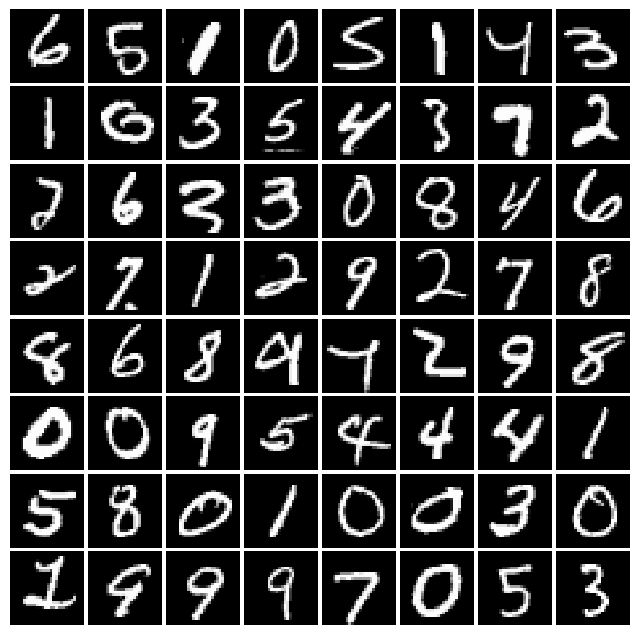

In [ ]:
# Fetch a batch of images from the training set
images, _ = next(iter(train_loader))
# Plot those images for demostration
display_images(images)



---


**<h1 align="center">GAN</h1>**



---



The Generator and Discriminator models are defined using PyTorch's nn.Module class. The generator network architecture is defined using nn.Sequential, which allows for a sequential arrangement of layers.

##**Generator class:**
---




The Generator takes random noise as input and passes it through a series of layers & activation functions:

####**2 * [CONV >> Batch Normalization >> Relu] >> CONV >> Tanh bold text**


Convolutional Transpose Layers:



* The first convolutional transpose layer upsamples the input noise (latent dim) to a higher resolution and increases the number of channels to 128. The kernel size, stride, and padding are set to achieve the desired output size.

* Next, Batch normalization is applied to normalize the activations of the previous layer, aiding in the stability and speed of training.

* Next, ReLU activation function is applied to introduce non-linearity and enhance the representation capacity of the network.

* This process is preformed twice, the second convolutional reduces the number of channels to 64.

* The final convolutional transpose layer upsamples the features to the desired output size, producing a single-channel image.

* Finally, the Tanh activation function is applied: 
    
        tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))

Forward Method:

* Reshapes the input noise tensor x to match the expected input shape of the first transpose convolutional layer. And passes the reshaped tensor through the layers defined in self.net.


In [ ]:
# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), latent_dim, 1, 1)
        x = self.net(x)
        return x

##**Discriminator class**


---


The Discriminator takes images as input and passes them through layers & activation functions:

####**CONV >> LeakyReLU >> 2* [CONV >> BatchNorm >> LeakyReLU]  >> CONV >> Sigmoid**

Convolutional Layers:


* The first convolutional layer takes in a single-channel image as input (in this case, the generated or real image) and applies 64 filters with a kernel size of 4x4, stride of 2, and padding of 1. This layer reduces the spatial dimensions of the input while increasing the number of channels.

* Next, LeakyReLU activation function is applied to introduce non-linearity.

* The second convolutional layer takes the features from the previous layer and applies 128 filters with the same kernel size, stride, and padding. This layer further reduces the spatial dimensions and increases the number of channels.
Next, Batch normalization is applied to normalize the activations of the previous layer, aiding in the stability and speed of training.

  Next, LeakyReLU activation is applied again.
The final convolutional layer reduces the spatial dimensions to 1x1 using a kernel size of 7x7, stride of 1, and no padding. This layer aims to capture the global information from the features.

* the third convolutional layer with 128 input channels (output from the previous layer), 256 output channels, a kernel size of 4x4, a stride of 2, a padding of 1, and no bias term. This layer further extracts more complex features from the previous layer's output.

  Batch and LeakyReLU are applied as well for the same resones as before.

* Finally, Sigmoid activation function is applied to squash the output to a probability score between 0 and 1.
    
      sigmoid(x) = 1 / (1 + e^(-x))



In [ ]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return x

###Done with the setups and class!

let's use all the above to create our GAN model, train it on our training set.



---

**<h1 align="center">Training</h1>**


---





Instances of the generator and discriminator are created and moved to the specified device.

In [ ]:
# Initialize Generator and Discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

The binary cross entropy loss function and Adam optimizers are defined for training the GAN.

In [ ]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))



**Training the Generator and Discriminator**

---


Training loop iterating over the specified number of epochs and batches.

Within each iteration, the discriminator is trained first by calculating the loss on real and fake images, and then updating its parameters using the optimizer.

The generator is trained by generating fake images, passing them through the discriminator, calculating the loss, and updating its parameters.

Progress and losses are printed at regular intervals to monitor the training process.

At the end of each epoch, a set of generated images is displayed.


Training Started!
Epoch [1/10], Step [250/750], D_loss: 0.3905, G_loss: 1.8542, D(x): 0.77, D(G(z)): 0.10
Epoch [1/10], Step [500/750], D_loss: 0.3576, G_loss: 1.5322, D(x): 0.75, D(G(z)): 0.03
Epoch [1/10], Step [750/750], D_loss: 0.1952, G_loss: 3.3735, D(x): 0.88, D(G(z)): 0.05


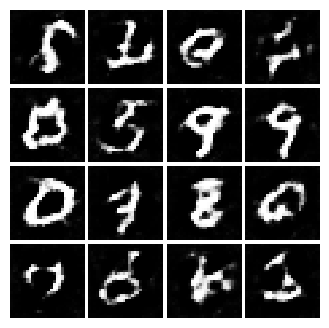

Epoch [2/10], Step [250/750], D_loss: 0.4502, G_loss: 2.5570, D(x): 0.88, D(G(z)): 0.25
Epoch [2/10], Step [500/750], D_loss: 0.0785, G_loss: 3.3396, D(x): 0.97, D(G(z)): 0.04
Epoch [2/10], Step [750/750], D_loss: 0.9851, G_loss: 8.2749, D(x): 1.00, D(G(z)): 0.49


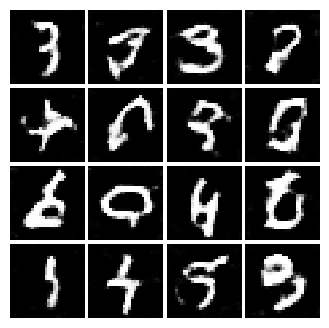

Epoch [3/10], Step [250/750], D_loss: 0.3159, G_loss: 2.4555, D(x): 0.76, D(G(z)): 0.01
Epoch [3/10], Step [500/750], D_loss: 0.1740, G_loss: 5.3845, D(x): 0.98, D(G(z)): 0.12
Epoch [3/10], Step [750/750], D_loss: 0.1725, G_loss: 4.9532, D(x): 0.98, D(G(z)): 0.13


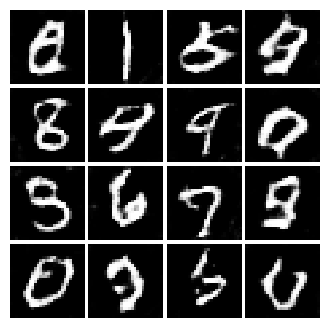

Epoch [4/10], Step [250/750], D_loss: 0.2851, G_loss: 3.2357, D(x): 0.91, D(G(z)): 0.16
Epoch [4/10], Step [500/750], D_loss: 0.0927, G_loss: 3.5805, D(x): 0.95, D(G(z)): 0.03
Epoch [4/10], Step [750/750], D_loss: 0.4408, G_loss: 2.9012, D(x): 0.99, D(G(z)): 0.31


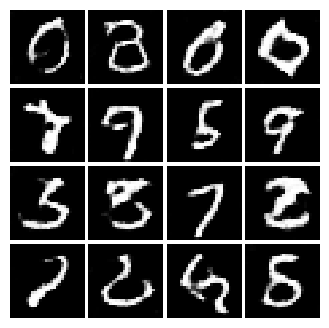

Epoch [5/10], Step [250/750], D_loss: 0.0796, G_loss: 4.1870, D(x): 0.94, D(G(z)): 0.02
Epoch [5/10], Step [500/750], D_loss: 0.1177, G_loss: 4.2142, D(x): 0.97, D(G(z)): 0.08
Epoch [5/10], Step [750/750], D_loss: 0.0430, G_loss: 4.5027, D(x): 0.98, D(G(z)): 0.02


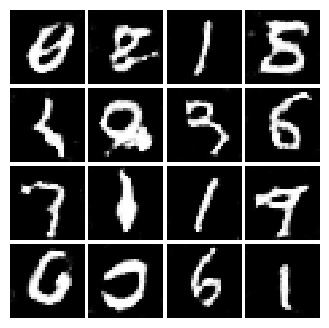

Epoch [6/10], Step [250/750], D_loss: 0.2167, G_loss: 2.5935, D(x): 0.87, D(G(z)): 0.07
Epoch [6/10], Step [500/750], D_loss: 0.0740, G_loss: 3.3181, D(x): 0.98, D(G(z)): 0.05
Epoch [6/10], Step [750/750], D_loss: 0.1129, G_loss: 3.8827, D(x): 0.94, D(G(z)): 0.04


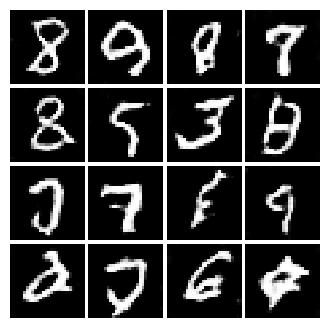

Epoch [7/10], Step [250/750], D_loss: 0.1108, G_loss: 4.2931, D(x): 0.98, D(G(z)): 0.08
Epoch [7/10], Step [500/750], D_loss: 0.1113, G_loss: 4.2324, D(x): 0.95, D(G(z)): 0.05
Epoch [7/10], Step [750/750], D_loss: 0.0712, G_loss: 4.7833, D(x): 0.96, D(G(z)): 0.02


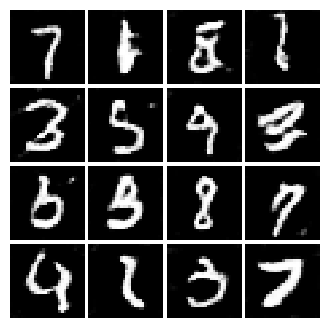

Epoch [8/10], Step [250/750], D_loss: 0.4111, G_loss: 1.7174, D(x): 0.71, D(G(z)): 0.01
Epoch [8/10], Step [500/750], D_loss: 0.4083, G_loss: 2.5906, D(x): 0.88, D(G(z)): 0.21
Epoch [8/10], Step [750/750], D_loss: 0.0462, G_loss: 5.1522, D(x): 0.98, D(G(z)): 0.03


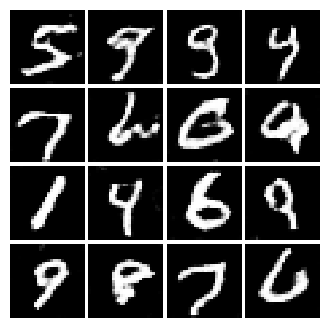

Epoch [9/10], Step [250/750], D_loss: 0.1026, G_loss: 3.9566, D(x): 0.99, D(G(z)): 0.08
Epoch [9/10], Step [500/750], D_loss: 0.0794, G_loss: 4.8725, D(x): 0.94, D(G(z)): 0.01
Epoch [9/10], Step [750/750], D_loss: 0.2360, G_loss: 3.6063, D(x): 0.95, D(G(z)): 0.14


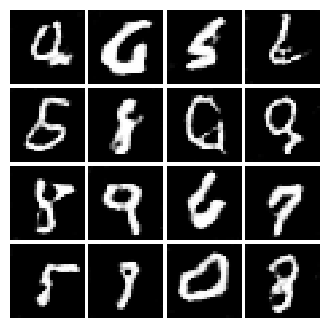

Epoch [10/10], Step [250/750], D_loss: 0.0607, G_loss: 6.1486, D(x): 0.95, D(G(z)): 0.01
Epoch [10/10], Step [500/750], D_loss: 0.1625, G_loss: 4.9928, D(x): 0.96, D(G(z)): 0.11
Epoch [10/10], Step [750/750], D_loss: 0.0708, G_loss: 3.4811, D(x): 0.98, D(G(z)): 0.05


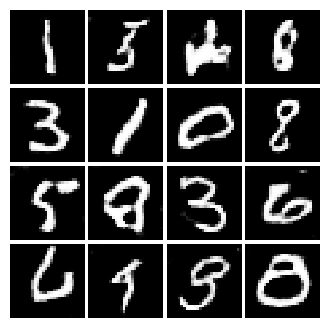

Training completed!


In [ ]:
print("Training Started!")
# Training loop
total_steps = len(train_loader)
print_every = total_steps / 3
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train Discriminator
        discriminator.zero_grad()
        real_labels = torch.ones((batch_size, 1)).to(device)
        fake_labels = torch.zeros((batch_size, 1)).to(device)

        # Real images
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)
        real_score = torch.mean(real_output).item()

        # Generate fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(noise)

        # Fake images
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        fake_score = torch.mean(fake_output).item()

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        discriminator.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        generator.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_g.step()

        # Print progress
        if (i+1) % (print_every) == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], "
                  f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}, "
                  f"D(x): {real_score:.2f}, D(G(z)): {fake_score:.2f}")

    # Generate images to show the progress over epoches
    with torch.no_grad():
        fake_images = generator(torch.randn(16, latent_dim).to(device))

        # Denormalize the generated images
        fake_images = fake_images * 0.5 + 0.5
        imgs_numpy = fake_images.data.cpu().numpy()
        display_images(imgs_numpy[0:16])
        plt.show()

print("Training completed!")



---


**<h1 align="center">Saving & Loading</h1>**


---

Saving our trained generator & discriminator


In [ ]:
torch.save(generator.state_dict(), f"/content/drive/MyDrive/GAN_project/generator.pt")
torch.save(discriminator.state_dict(), f"/content/drive/MyDrive/GAN_project/discriminator.pt")

####**Loading**

Taking our generator model for a test

In [ ]:
# Load the generator model
loaded_generator = Generator().to(device)
loaded_generator.load_state_dict(torch.load("/content/drive/MyDrive/GAN_project/generator.pt"))
# Load the discriminator model
loaded_discriminator = Discriminator().to(device)
loaded_discriminator.load_state_dict(torch.load("/content/drive/MyDrive/GAN_project/discriminator.pt"))

<All keys matched successfully>


---


**<h1 align="center">Results</h1>**


---
Our goal was to train the generator in order to fool the descriminator into thinking the generated data is human writing numbers. Let's see the resualts.


Taking our generator model for a test drive

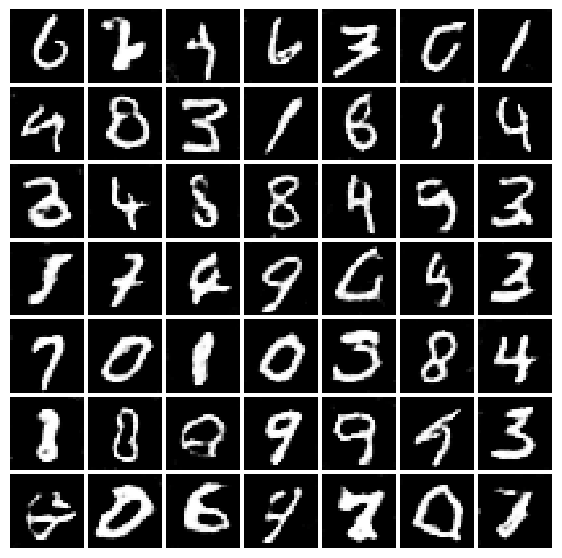

In [ ]:
# Generate new numbers
generate_num = 49
with torch.no_grad():
    fake_images = loaded_generator(torch.randn(generate_num, latent_dim).to(device))
    fake_images = fake_images * 0.5 + 0.5  # Denormalize the generated images
    imgs_numpy = fake_images.data.cpu().numpy()
    display_images(imgs_numpy[0:generate_num])
    plt.show()

In [ ]:
# Set the discriminator to evaluation mode
loaded_discriminator.eval()

# Test the discriminator
num_samples = 10

# Generate fake images
with torch.no_grad():
    noise = torch.randn(num_samples, latent_dim, 1, 1).to(device)
    fake_images = loaded_generator(noise)

# Load a batch of real images from the dataset
real_images, _ = next(iter(train_loader))
real_images = real_images[:num_samples].to(device)

# Pass both real and fake images through the discriminator
with torch.no_grad():
    real_output = loaded_discriminator(real_images)
    fake_output = loaded_discriminator(fake_images)

# Print the discriminator outputs
print("Discriminator Outputs:\n", "Real Images:\n", real_output, "\nFake Images:\n", fake_output)

Discriminator Outputs:
 Real Images:
 tensor([[0.9810],
        [0.8953],
        [0.9694],
        [0.9912],
        [0.8853],
        [0.8803],
        [0.8496],
        [0.9492],
        [0.9213],
        [0.8311]]) 
Fake Images:
 tensor([[0.6576],
        [0.2884],
        [0.3611],
        [0.9159],
        [0.5985],
        [0.2250],
        [0.7511],
        [0.1585],
        [0.9011],
        [0.5314]])


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Create an empty list to store the discriminator's predictions
predictions = []

# Set the discriminator to evaluation mode
loaded_discriminator.eval()

# Iterate over the test DataLoader
with torch.no_grad():
    for real_images, _ in test_loader:
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Get the discriminator's output for real images
        real_output = loaded_discriminator(real_images)
        predictions.extend(real_output.cpu().numpy())

    # Convert the predictions list to a binary numpy array
    predictions = (np.array(predictions) >= 0.5).astype(int)

# Create ground truth labels (assuming real images have label 1)
ground_truth = np.ones_like(predictions)

# Calculate precision, recall, and F1-score
precision = precision_score(ground_truth, predictions)
recall = recall_score(ground_truth, predictions)
f1 = f1_score(ground_truth, predictions)

# Print the evaluation metrics
print("Results:\n\tPrecision:", precision, "\n\tRecall:", recall, "\n\tF1-Score:", f1)

Results:
	Precision: 1.0 
	Recall: 0.9643333333333334 
	F1-Score: 0.9818428644154081
